In [42]:
import pandas as pd
import numpy as np
import random as random
import pyarrow as pa 
import pyarrow.parquet as pq
from fastavro import writer, reader, parse_schema
import collections
import ta
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import os
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.fftpack import fft, ifft
%matplotlib inline
import matplotlib.pyplot as plt

In [43]:
df = pq.read_table("./check.parquet").to_pandas()

/home/thorad/.local/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/thorad/.local/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/thorad/.local/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [45]:
df.columns

Index(['high', 'low', 'close', 'volume', 'all_rsi', 'all_mfi', 'all_tsi',
       'all_uo', 'all_ao', 'all_macd_diff', 'all_vortex_pos', 'all_vortex_neg',
       'all_vortex_diff', 'all_trix', 'all_mass_index', 'all_cci', 'all_dpo',
       'all_kst', 'all_kst_sig', 'all_kst_diff', 'all_aroon_up',
       'all_aroon_down', 'all_aroon_ind', 'all_bbh', 'all_bbl', 'all_bbm',
       'all_bbhi', 'all_bbli', 'all_kchi', 'all_kcli', 'all_dchi', 'all_dcli',
       'all_adi', 'all_obv', 'all_cmf', 'all_fi', 'all_em', 'all_vpt',
       'all_nvi', 'all_dr', 'all_dlr', 'all_ma50', 'all_ma100', 'all_26ema',
       'all_12ema', 'all_macd', 'all_100sd', 'all_upper_band',
       'all_lower_band', 'all_ema', 'all_momentum', 'close_price',
       'high_price', 'all_volume'],
      dtype='object')

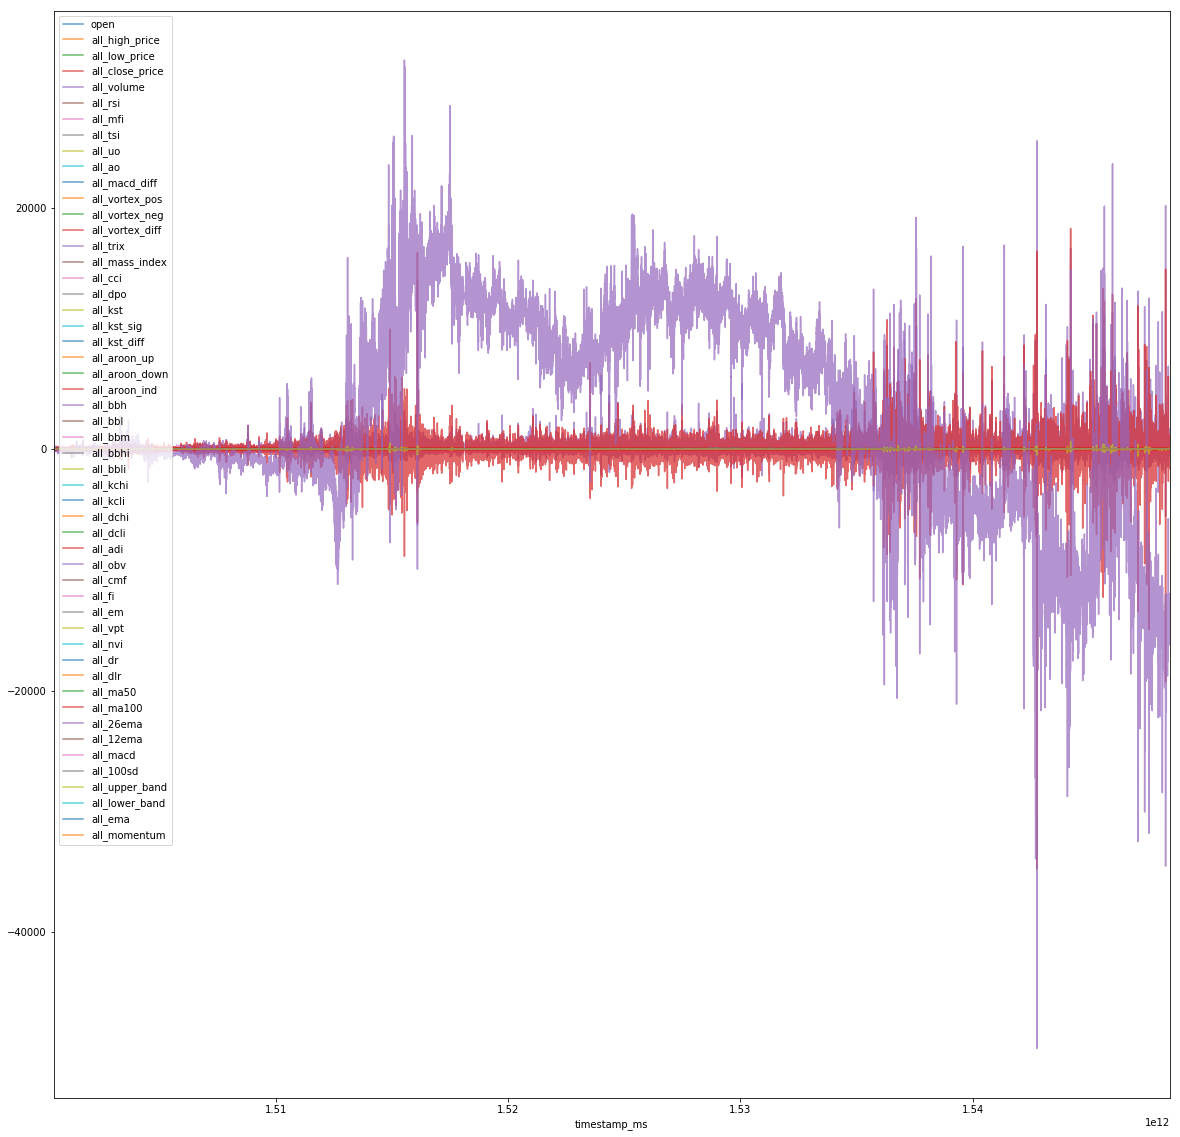

In [13]:
df.plot(figsize=(20,20), alpha=0.7)

In [14]:
def add_candle_indicators(
    df, 
    l, 
    ck, 
    hk, 
    lk, 
    vk
):
    df[l+'rsi'] = ta.rsi(df[ck])
    df[l+'mfi'] = ta.money_flow_index(df[hk], df[lk], df[ck], df[vk])
    df[l+'tsi'] = ta.tsi(df[ck])
    df[l+'uo'] = ta.uo(df[hk], df[lk], df[ck])
    df[l+'ao'] = ta.ao(df[hk], df[lk])
    df[l+'macd_diff'] = ta.macd_diff(df[ck])
    df[l+'vortex_pos'] = ta.vortex_indicator_pos(df[hk], df[lk], df[ck])
    df[l+'vortex_neg'] = ta.vortex_indicator_neg(df[hk], df[lk], df[ck])
    df[l+'vortex_diff'] = abs(df[l+'vortex_pos'] - df[l+'vortex_neg'])
    df[l+'trix'] = ta.trix(df[ck])
    df[l+'mass_index'] = ta.mass_index(df[hk], df[lk])
    df[l+'cci'] = ta.cci(df[hk], df[lk], df[ck])
    df[l+'dpo'] = ta.dpo(df[ck])
    df[l+'kst'] = ta.kst(df[ck])
    df[l+'kst_sig'] = ta.kst_sig(df[ck])
    df[l+'kst_diff'] = (df[l+'kst']-df[l+'kst_sig'])
    df[l+'aroon_up'] = ta.aroon_up(df[ck])
    df[l+'aroon_down'] = ta.aroon_down(df[ck])
    df[l+'aroon_ind'] = (df[l+'aroon_up']-df[l+'aroon_down'])
    df[l+'bbh'] = ta.bollinger_hband(df[ck])
    df[l+'bbl'] = ta.bollinger_lband(df[ck])
    df[l+'bbm'] = ta.bollinger_mavg(df[ck])
    df[l+'bbhi'] = ta.bollinger_hband_indicator(df[ck])
    df[l+'bbli'] = ta.bollinger_lband_indicator(df[ck])
    df[l+'kchi'] = ta.keltner_channel_hband_indicator(df[hk],df[lk],df[ck])
    df[l+'kcli'] = ta.keltner_channel_lband_indicator(df[hk],df[lk],df[ck])
    df[l+'dchi'] = ta.donchian_channel_hband_indicator(df[ck])
    df[l+'dcli'] = ta.donchian_channel_lband_indicator(df[ck])
    df[l+'adi'] = ta.acc_dist_index(df[hk],df[lk],df[ck],df[vk])
    df[l+'obv'] = ta.on_balance_volume(df[ck], df[vk])
    df[l+'cmf'] = ta.chaikin_money_flow(df[hk],df[lk],df[ck],df[vk])
    df[l+'fi'] = ta.force_index(df[ck], df[vk])
    df[l+'em'] = ta.ease_of_movement(df[hk], df[lk], df[ck], df[vk])
    df[l+'vpt'] = ta.volume_price_trend(df[ck], df[vk])
    df[l+'nvi'] = ta.negative_volume_index(df[ck], df[vk])
    df[l+'dr'] = ta.daily_return(df[ck])
    df[l+'dlr'] = ta.daily_log_return(df[ck])
    
    df[l+'ma50'] = df[ck].rolling(window=50).mean()
    df[l+'ma100'] = df[ck].rolling(window=100).mean()    
    df[l+'26ema'] = df[[ck]].ewm(span=26).mean()
    df[l+'12ema'] = df[[ck]].ewm(span=12).mean()
    df[l+'macd'] = (df[l+'12ema']-df[l+'26ema'])
    df[l+'100sd'] = df[[ck]].rolling(100).std()
    df[l+'upper_band'] = df[l+'ma100'] + (df[l+'100sd']*2)
    df[l+'lower_band'] = df[l+'ma100'] - (df[l+'100sd']*2)
    df[l+'ema'] = df[ck].ewm(com=0.5).mean()
    df[l+'momentum'] = df[ck]-1
    return df

In [33]:
adf = pq.read_table("../data/Binance_5m_ETHBTC.parquet").to_pandas()

/home/thorad/.local/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [34]:
adf.drop(columns=[
    'close_timestamp_ms', 
    'quote_asset_volume',
    'trades',
    'taker_buy_quote_asset_volume',
    'taker_buy_base_asset_volume',
    'ignore'
], inplace=True)

numeric_fields = ['open', 'high', 'low', 'close', 'volume']
for f in numeric_fields:
    adf[f] = pd.to_numeric(adf[f])

adf.rename(
    columns={
        "close": "all_close_price", 
        "volume":"all_volume", 
        "high": "all_high_price",
        "low": "all_low_price",
    }, 
    inplace=True
)

In [35]:
adf = adf.loc[~adf.index.duplicated(keep='first')]

In [36]:
adf.sort_values(['timestamp_ms'], inplace=True)

adf = add_candle_indicators(
    adf,
    l='all_', 
    ck='all_close_price', 
    hk='all_high_price', 
    lk='all_low_price', 
    vk='all_volume'
)

In [37]:
adf.set_index(['timestamp_ms'], inplace=True)
adf.sort_index(inplace=True)

In [39]:
adf.columns

Index(['open', 'all_high_price', 'all_low_price', 'all_close_price',
       'all_volume', 'all_rsi', 'all_mfi', 'all_tsi', 'all_uo', 'all_ao',
       'all_macd_diff', 'all_vortex_pos', 'all_vortex_neg', 'all_vortex_diff',
       'all_trix', 'all_mass_index', 'all_cci', 'all_dpo', 'all_kst',
       'all_kst_sig', 'all_kst_diff', 'all_aroon_up', 'all_aroon_down',
       'all_aroon_ind', 'all_bbh', 'all_bbl', 'all_bbm', 'all_bbhi',
       'all_bbli', 'all_kchi', 'all_kcli', 'all_dchi', 'all_dcli', 'all_adi',
       'all_obv', 'all_cmf', 'all_fi', 'all_em', 'all_vpt', 'all_nvi',
       'all_dr', 'all_dlr', 'all_ma50', 'all_ma100', 'all_26ema', 'all_12ema',
       'all_macd', 'all_100sd', 'all_upper_band', 'all_lower_band', 'all_ema',
       'all_momentum'],
      dtype='object')